# 영화별 개봉 후 D일차 관객수 예측 모델 구축

In [1]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import holidays

# 모델 구축 라이브러리
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib.collections import PolyCollection

# 시계열 분석 라이브러리
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf

from time import time

In [2]:
# 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
# 데이터 불러오기
raw_data = pd.read_csv('movie_finished_toFDA_V9.csv')
print(raw_data.shape)
raw_data.head()

(6135, 172)


,naver_movie_code,kobis_movie_code,movie_title,release_date,DoW_release,Date,DoW,MoY,D_D,DailyTotal,...,국적평균누적관객수,국적평균스크린수,등급평균관객수,등급평균누적관람객수,등급평균스크린수,7days_before,5days_before,Day_of_release,5days_after,7days_after
0,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-07,Thursday,January,0,612,...,859493,95,9090,596341,79,11,11,13,6,33
1,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-08,Friday,January,1,332,...,859493,95,9090,596341,79,11,11,13,6,33
2,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-09,Saturday,January,2,394,...,859493,95,9090,596341,79,11,11,13,6,33
3,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-10,Sunday,January,3,205,...,859493,95,9090,596341,79,11,11,13,6,33
4,107374,20142641,나를 잊지 말아요,2016-01-07,Thursday,2016-01-11,Monday,January,4,246,...,859493,95,9090,596341,79,11,11,13,6,33


In [4]:
pd.set_option('display.max_columns', None)

# 데이터 타입 확인
pd.DataFrame(raw_data.dtypes).T

,naver_movie_code,kobis_movie_code,movie_title,release_date,DoW_release,Date,DoW,MoY,D_D,DailyTotal,RV_Total,NTZ_Total,Total_Negative,RV_Negative,NTZ_Negative,Total_Neutral,RV_Neutral,NTZ_Neutral,Total_Positive,RV_Positive,NTZ_Positive,Total_Dailyscore,RV_Dailyscore,NTZ_Dailyscore,Total_neg_ratio,Total_neut_ratio,Total_pos_ratio,RV_neg_ratio,RV_neut_ratio,RV_pos_ratio,NTZ_neg_ratio,NTZ_neut_ratio,NTZ_pos_ratio,Total_Entropy,RV_Entropy,NTZ_Entropy,스크린수,스크린점유율,상영횟수,상영점유율,좌석수,좌석점유율,좌석판매율,매출액,매출액증감(전일대비),관객수,관객수증감(전일대비),누적매출액,누적관객수,순위,nationality,genre,사극,SF,어드벤처,액션,범죄,판타지,가족,미스터리,스릴러,뮤지컬,코미디,공포(호러),애니메이션,드라마,서부극(웨스턴),전쟁,멜로/로맨스,기타,다큐멘터리,공연,성인물(에로),장르1평균관객수,장르2평균관객수,장르3평균관객수,장르1평균누적관객수,장르2평균누적관객수,장르3평균누적관객수,장르1평균스크린수,장르2평균스크린수,장르3평균스크린수,장르평균관객수,장르평균누적관객수,장르평균스크린수,directors,감독군,directors_naver_code,actors,actors_naver_code,actor_power,director_power,rev_acc,RV_male,RV_female,RV_teen,RV_twenties,RV_thirties,RV_forties,RV_fifties,NTZ_score_total,NTZ_review_total,NTZ_male_score,NTZ_female_score,NTZ_teen_score,NTZ_twenties_score,NTZ_thirties_score,NTZ_forties_score,NTZ_fifties_more_score,NTZ_direct_point,NTZ_act_point,NTZ_story_point,NTZ_visual_point,NTZ_ost_point,RV_score_total,RV_review_total,RV_male_score,RV_female_score,RV_teen_score,RV_twenties_score,RV_thirties_score,RV_forties_score,RV_fifties_more_score,RV_direct_point,RV_act_point,RV_story_point,RV_visual_point,RV_ost_point,running_time,watch_grade,제작사,배급사,제공,배급사군,영화명(검색),비교영화1(검색),비교영화2(검색),비교영화3(검색),비교영화4(검색),영화명_검색량,비교영화1_검색량,비교영화2_검색량,비교영화3_검색량,비교영화4_검색량,감독평균최대관객수,log_감독평균최대관객수,감독총최대관객수,log_감독총최대관객수,배급사평균최대관객수,log_배급사평균최대관객수,배급사총최대관객수,log_배급사총최대관객수,요일평균관객수,요일평균누적관객수,요일평균스크린수,월평균관객수,월평균누적관객수,월평균스크린수,장르평균관객수.1,장르평균누적관객수.1,장르평균스크린수.1,국적평균관객수,국적평균누적관객수,국적평균스크린수,등급평균관객수,등급평균누적관람객수,등급평균스크린수,7days_before,5days_before,Day_of_release,5days_after,7days_after
0,int64,int64,object,object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,object,int64,float64,int64,float64,int64,float64,float64,int64,object,int64,object,int64,int64,int64,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,float64,object,object,object,float64,float64,float64,object,object,object,object,object,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,int64,object,object,object,object,int64,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


## 0. 데이터 전처리

In [5]:
# 사용할 컬럼들 정의
features = [
    'kobis_movie_code', 'movie_title',  # 영화 코드, 제목
    'release_date', 'DoW_release', 'Date', 'DoW', 'MoY', 'D_D',  # 날짜 관련 변수
    '관객수',
    'DailyTotal',  # 하루 별 총 리뷰 개수
    'NTZ_score_total', 'RV_score_total',  # 해당 일차 영화별 평균 평점
    '영화명_검색량', '비교영화1_검색량', '비교영화2_검색량', '비교영화3_검색량', '비교영화4_검색량',  # 검색량
]

# 원하는 컬럼만 추출
data = raw_data[features].copy()

### 데이터 전처리 - 데이터 타입 변환

In [6]:
# 1. 날짜형 데이터 타입 변형
datetime_columns = ['release_date', 'Date']

for col in datetime_columns:
    try:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        print(f"Converted {col} to datetime.")
    except Exception as e:
        print(f"Error converting {col} to datetime: {e}")

Converted release_date to datetime.
Converted Date to datetime.


In [7]:
# 2. 잘 변경되었는지 날짜형 데이터를 출력하여 확인
# Datetime 타입 열만 필터링
datetime_columns = data.select_dtypes(include=['datetime64'])

# Datetime 타입 열 전체 데이터 출력
print("Datetime 타입 열 데이터:")
print(datetime_columns.head())

print("데이터 타입: \n" + str(datetime_columns.dtypes))

Datetime 타입 열 데이터:
  release_date       Date
0   2016-01-07 2016-01-07
1   2016-01-07 2016-01-08
2   2016-01-07 2016-01-09
3   2016-01-07 2016-01-10
4   2016-01-07 2016-01-11
데이터 타입: 
release_date    datetime64[ns]
Date            datetime64[ns]
dtype: object


### 데이터 전처리 - 공휴일 열 만들기

In [8]:
# 대한민국 공휴일 객체 생성 (2016년 ~ 2019년)
kr_holidays = holidays.KR(years=range(2016, 2020))

# 공휴일 여부 확인 및 Holiday 열 생성
data['Holiday'] = data['Date'].apply(lambda x: 1 if x in kr_holidays else 0)

### 데이터 전처리 - 주말 열 만들기

In [9]:
# Weekend 열 생성: 토요일(Saturday)이나 일요일(Sunday)면 1, 아니면 0
data['Weekend'] = data['DoW'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

### 데이터 전처리 - 방학 열 만들기

In [10]:
# Vacation 열 생성: 월이 1, 2, 7, 8이면 1, 아니면 0
data['Vacation'] = data['Date'].dt.month.apply(lambda x: 1 if x in [1, 2, 7, 8] else 0)

### 데이터 전처리 - 영화 검색량 비율 정규화

In [11]:
search_columns = ['영화명_검색량', '비교영화1_검색량', '비교영화2_검색량', '비교영화3_검색량', '비교영화4_검색량']

# 각 행 별로 search_columns의 최대값을 구해서 나누기
for i, row in data[search_columns].iterrows():
    max_value = row.max()
    data.loc[i, search_columns] = row / max_value

### 파생변수 생성 - 영화 평점

In [12]:
# 네티즌과 실제 관객 평점을 합산하여 총 평점을 구함
data['score_total'] = data['NTZ_score_total'] + data['RV_score_total']

### 파생변수 생성 - 댓글 참여도

In [13]:
# 댓글 참여도 = 영화별 하루 총 리뷰 개수 / 관객수
data['review_participation'] = data['DailyTotal'] / data['관객수']

### 파생변수 생성 - 최근 히트 영화 개수

In [14]:
# D_D 기준으로 5일전 내에 개봉한 영화 리스트 생성
day = 5
column_name = f"list_movies_released_{day}_days_before"  # 컬럼 이름 생성
data[column_name] = data.apply(
    lambda row: data[
        (data['release_date'] >= (row['Date'] - pd.Timedelta(days=day))) &  # 기간 설정: Date - day
        (data['release_date'] <= row['Date'])                              # 기간 설정: Date
    ]['movie_title'].drop_duplicates().tolist(),  # 중복 제거 후 리스트화
    axis=1
)

In [15]:
## hit_movies 필터링 & count
def calculate_movie_power_and_list(row, df):
    # 1. 3_before_movie_list에서 영화 리스트를 가져옴
    movie_list = row["list_movies_released_5_days_before"]

    # 2. 해당 영화 리스트의 영화들을 'movie_title'에서 필터링
    relevant_rows = df[
        (df["movie_title"].isin(movie_list)) &  # 영화 제목이 리스트에 있고
        (df["D_D"] == 0)                       # D_D 값이 0인 경우
    ]

    # 3. 관객수가 30만이 넘는 영화 필터링
    hit_movie_list = relevant_rows[relevant_rows["관객수"] >= 300000]["movie_title"].tolist()

    # 4. movie_power 계산 (30만 넘는 영화 개수)
    hit_movie_power = len(hit_movie_list)  # 30만 넘는 영화의 개수

    return hit_movie_power, hit_movie_list

# movie_power와 movie_power_list 컬럼 추가
data[["hit_movie_power", "hit_movie_list"]] = data.apply(
    lambda row: pd.Series(calculate_movie_power_and_list(row, data)), axis=1
)

### 파생변수 생성 - 일별 영화수요 변수
상위 10개 영화의 일별 관객수 총합을 시계열 데이터로 구하여 차후 일자 영화수요를 forecasting 하기로 하였습니다.

여기서 사용한 데이터는 SARIMAX_model.ipynb에서 구축한 데이터를 불러와 사용하였습니다.

해당 날짜의 실제 총 관객수가 actual에 담겨있고, 차후 날짜들에 대한 forecasting이 같은 행에 나열되어 있습니다.

In [172]:
# 시계열 데이터를 불러옵니다
ts_data = pd.read_csv('./processed_data/TS_data.csv', index_col=0)
# 인덱스를 날짜형으로 변환
ts_data.index = pd.to_datetime(ts_data.index)
print(ts_data.shape)
ts_data.tail()

(1301, 8)


,actual,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6,forecast_7
date,,,,,,,,
2019-07-20,1212757,1.082469e+06,454244.151045,4.682548e+05,6.658179e+05,5.861911e+05,6.962209e+05,1.254071e+06
2019-07-21,1124807,4.779272e+05,487768.383213,6.816723e+05,5.989710e+05,7.065242e+05,1.262179e+06,1.158246e+06
2019-07-22,336153,4.089851e+05,615519.985202,5.436153e+05,6.621400e+05,1.227807e+06,1.130525e+06,4.727834e+05
2019-07-23,322864,5.665904e+05,502345.413048,6.262573e+05,1.198893e+06,1.106238e+06,4.527929e+05,4.626143e+05
2019-07-24,469326,4.490593e+05,581936.740098,1.160568e+06,1.074242e+06,4.257978e+05,4.396911e+05,6.201993e+05


---

## 1. 단순 EDA
대부분의 EDA는 Tableau로 진행하여, Python에서 한 EDA의 코드만 포함했습니다.

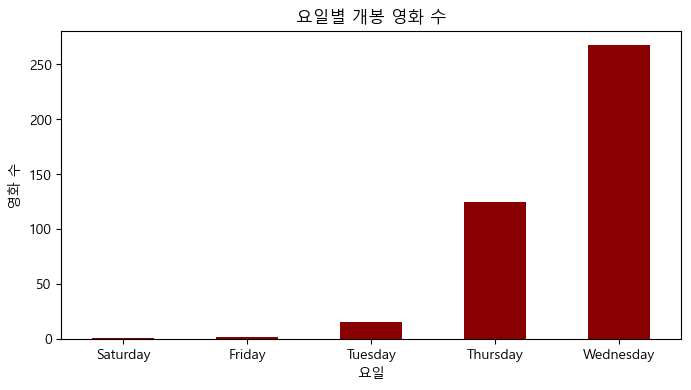

In [25]:
# 요일별 개봉 영화 수 시각화
plt.figure(figsize=(8, 4))
data.groupby('DoW_release')['kobis_movie_code'].nunique().sort_values().plot(kind='bar', color='#8B0000')
plt.title('요일별 개봉 영화 수')
plt.xlabel('요일')
plt.ylabel('영화 수')
plt.xticks(rotation=0)
plt.show()

영화 중 대부분 영화가 수요일 또는 목요일에 개봉되어 두 요일에 개봉된 영화만 추려서 분석하였습니다.

In [26]:
# 영화 중 수목에 개봉한 영화만 추출
data = data[data['DoW_release'].isin(['Wednesday', 'Thursday'])]

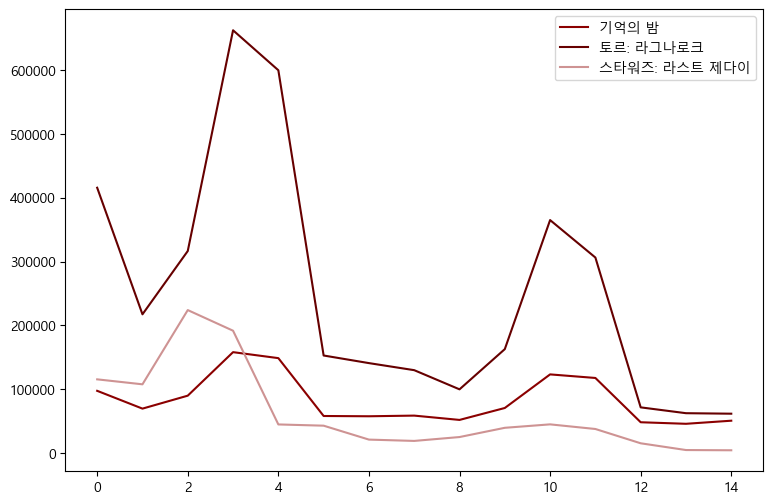

In [28]:
# 특정 영화만 추출하여 14일간 일별 관객수 시각화
movie_data_1 = data[data['movie_title'] == '기억의 밤']
movie_data_2 = data[data['movie_title'] == '토르: 라그나로크']
movie_data_3 = data[data['movie_title'] == '스타워즈: 라스트 제다이']

plt.figure(figsize=(9, 6))
plt.plot(movie_data_1['관객수'].values, label='기억의 밤', color='#8B0000')
plt.plot(movie_data_2['관객수'].values, label='토르: 라그나로크', color='#660000')
plt.plot(movie_data_3['관객수'].values, label='스타워즈: 라스트 제다이', color='#CE9393')
plt.legend()
plt.show()

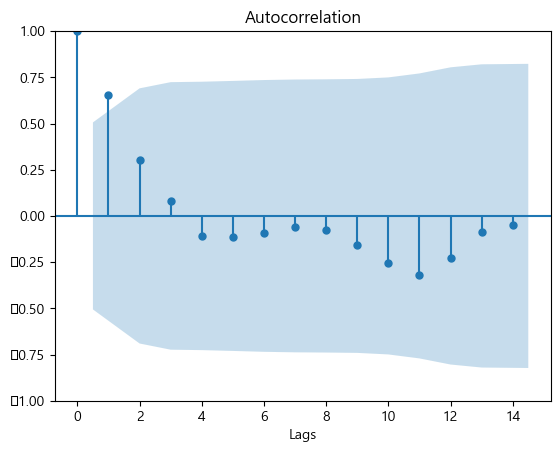

In [65]:
# ACF 그래프 시각화
plot_acf(movie_data_3['관객수'], lags=14)
plt.xlabel('Lags')
plt.show()

---

## 2. 데이터 구축

d일차까지의 데이터를 사용하여 D일차 관객수를 예측한다고 할때

### i) d일차까지의 데이터

In [145]:
daily_cols = ['관객수', '영화명_검색량', 'review_participation']  # 일별 변수들
movie_lvl_cols = ['score_total', 'hit_movie_power']  # 영화별 변수들

# D_D 기준으로 데이터 피벗
pivoted_data_d = data.pivot(index=['kobis_movie_code', 'movie_title'], columns='D_D', values=daily_cols + movie_lvl_cols)

# 컬럼 이름 변경
pivoted_data_d.columns = [f"{col}_{i}" for col, i in pivoted_data_d.columns]

# Review_participation의 평균을 구함
for i in range(0, 15):
        pivoted_data_d[f"review_participation_mean_{i}"] = pivoted_data_d[[f"review_participation_{j}" for j in range(0, i + 1)]].mean(axis=1)

# 기존 review_participation 컬럼 삭제
pivoted_data_d.drop(columns=[f"review_participation_{i}" for i in range(0, 15)], inplace=True)

# 개봉일 컬럼 추가
pivoted_data_d['release_date'] = data.groupby(['kobis_movie_code', 'movie_title'])['release_date'].first()

In [146]:
pivoted_data_d.head(3)

,,관객수_0,관객수_1,관객수_2,관객수_3,관객수_4,관객수_5,관객수_6,관객수_7,관객수_8,관객수_9,관객수_10,관객수_11,관객수_12,관객수_13,관객수_14,영화명_검색량_0,영화명_검색량_1,영화명_검색량_2,영화명_검색량_3,영화명_검색량_4,영화명_검색량_5,영화명_검색량_6,영화명_검색량_7,영화명_검색량_8,영화명_검색량_9,영화명_검색량_10,영화명_검색량_11,영화명_검색량_12,영화명_검색량_13,영화명_검색량_14,score_total_0,score_total_1,score_total_2,score_total_3,score_total_4,score_total_5,score_total_6,score_total_7,score_total_8,score_total_9,score_total_10,score_total_11,score_total_12,score_total_13,score_total_14,hit_movie_power_0,hit_movie_power_1,hit_movie_power_2,hit_movie_power_3,hit_movie_power_4,hit_movie_power_5,hit_movie_power_6,hit_movie_power_7,hit_movie_power_8,hit_movie_power_9,hit_movie_power_10,hit_movie_power_11,hit_movie_power_12,hit_movie_power_13,hit_movie_power_14,review_participation_mean_0,review_participation_mean_1,review_participation_mean_2,review_participation_mean_3,review_participation_mean_4,review_participation_mean_5,review_participation_mean_6,review_participation_mean_7,review_participation_mean_8,review_participation_mean_9,review_participation_mean_10,review_participation_mean_11,review_participation_mean_12,review_participation_mean_13,review_participation_mean_14,release_date
kobis_movie_code,movie_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20068576,그날의 분위기,67607.0,68328.0,111188.0,100689.0,43069.0,37505.0,39483.0,19951.0,21592.0,34686.0,26903.0,14311.0,14301.0,16109.0,4229.0,1.000000,0.722485,0.618088,0.543688,0.738166,0.803431,0.796676,0.257761,0.255003,0.349609,0.342024,0.365964,0.432039,0.411218,0.090335,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,14.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004393,0.003206,0.002581,0.002378,0.002501,0.002516,0.002464,0.002726,0.002773,0.002715,0.002698,0.002706,0.002740,0.002717,0.003040,2016-01-14
20140704,비밀은 없다,53485.0,44302.0,51512.0,41340.0,18830.0,17817.0,4341.0,2277.0,1906.0,2009.0,1871.0,1670.0,1842.0,753.0,665.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.038129,0.115434,0.206284,0.110206,0.184204,0.118013,0.097244,0.014587,0.296436,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,13.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008563,0.008491,0.007764,0.007232,0.006911,0.006489,0.007339,0.008673,0.009225,0.009248,0.009573,0.009873,0.009740,0.011131,0.014099,2016-06-23
20142406,탐정 홍길동: 사라진 마을,82893.0,192319.0,188592.0,171697.0,148710.0,55279.0,60426.0,40969.0,29117.0,47559.0,97119.0,82044.0,33175.0,23936.0,24174.0,0.147016,0.164747,0.175558,0.163379,0.194356,0.202400,0.232062,0.013441,0.013064,0.018813,0.021288,0.019151,0.019110,0.019192,0.022834,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,15.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005549,0.004374,0.004231,0.003971,0.003946,0.004537,0.004799,0.005001,0.005388,0.005402,0.005193,0.005088,0.005328,0.005398,0.005402,2016-05-04


### ii) 예측 일자에 관련된 데이터

In [ ]:
# 14일 이전 데이터 정리
pre_14_data = data[['kobis_movie_code', 'movie_title', 'release_date', 'Date', 'D_D', '관객수']].copy()
pre_14_data.rename(columns={'Date': 'date', '관객수': 'y_audiCnt'}, inplace=True)
pre_14_data.head(3)

,kobis_movie_code,movie_title,release_date,date,D_D,y_audiCnt
0,20142641,나를 잊지 말아요,2016-01-07,2016-01-07,0,63347
1,20142641,나를 잊지 말아요,2016-01-07,2016-01-08,1,55628
2,20142641,나를 잊지 말아요,2016-01-07,2016-01-09,2,94370
3,20142641,나를 잊지 말아요,2016-01-07,2016-01-10,3,81261
4,20142641,나를 잊지 말아요,2016-01-07,2016-01-11,4,30127


In [ ]:
# 14일 이후 데이터 불러오기
post_14_data = pd.read_csv('processed_data/audi_cnt_after_14.csv')
post_14_data = post_14_data.drop_duplicates(keep='first')

# 날짜 데이터 타입 변경
post_14_data['openDt'] = pd.to_datetime(post_14_data['openDt'])
post_14_data['date'] = pd.to_datetime(post_14_data['date'])
post_14_data.head(3)

,movieCd,movieNm,openDt,date,D_D,audiCnt
0,20068576,그날의 분위기,2016-01-14,2016-01-28,14,4229
1,20068576,그날의 분위기,2016-01-14,2016-01-31,17,6317
2,20068576,그날의 분위기,2016-01-14,2016-01-30,16,6650
3,20068576,그날의 분위기,2016-01-14,2016-02-01,18,2750
4,20068576,그날의 분위기,2016-01-14,2016-02-02,19,2573


In [94]:
# 두 데이터를 병합
post_14_data.columns = pre_14_data.columns
data_D = pd.concat([pre_14_data, post_14_data], axis=0).set_index(['kobis_movie_code', 'movie_title'])
data_D = data_D.sort_values(['kobis_movie_code', 'date'])

In [ ]:
# Weekend, Vacation, Holiday정보를 date기준으로 추가
data_D['Weekend'] = data_D['date'].dt.dayofweek.apply(lambda x: 1 if x in [5, 6] else 0).astype(int)
data_D['Vacation'] = data_D['date'].dt.month.apply(lambda x: 1 if x in [1, 2, 7, 8] else 0).astype(int)
data_D['Holiday'] = data_D['date'].apply(lambda x: 1 if x in kr_holidays else 0).astype(int)
data_D.head(3)

release_date       date  D_D  y_audiCnt  Weekend  \
kobis_movie_code movie_title                                                    
20068576         그날의 분위기       2016-01-14 2016-01-14    0      67607        0   
                 그날의 분위기       2016-01-14 2016-01-15    1      68328        0   
                 그날의 분위기       2016-01-14 2016-01-16    2     111188        1   
                 그날의 분위기       2016-01-14 2016-01-17    3     100689        1   
                 그날의 분위기       2016-01-14 2016-01-18    4      43069        0   

                              Vacation  Holiday  
kobis_movie_code movie_title                     
20068576         그날의 분위기             1        0  
                 그날의 분위기             1        0  
                 그날의 분위기             1        0  
                 그날의 분위기             1        0  
                 그날의 분위기             1        0

## 최종 모델 구축

### 사용 모델 리스트

In [117]:
# 회귀 모델 리스트
models = {'LinearRegression': LinearRegression(),
          'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
          'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)}

### 시각화용 함수 정의 - RMSE, MAE, MAPE 플롯

In [130]:
def plot_prediction_error(df, days_to_use):
    colors = ['orange', 'purple', 'green']

    figure, ax = plt.subplots(2, 1, figsize=(10, 12))
    # Plot 1: MAE, RMSE
    for model_name, color in zip(df['Model'].unique(), colors):
        model_results = df[(df['Model'] == model_name) & (df['Days to Use'] == days_to_use)]

        # Plot 1: MAE, RMSE
        ax[0].plot(model_results['Predict Day'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
        ax[0].plot(model_results['Predict Day'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')
        # Plot 2: MAPE
        ax[1].plot(model_results['Predict Day'], model_results['MAPE'], label=model_name+'_MAPE', color=color, marker='o')
        
    ax[0].set_ylabel('Error')
    ax[0].set_title('MAE, RMSE by Predict Day')
    ax[0].legend(loc='upper left')

    ax[1].set_xlabel('Predict Day')
    ax[1].set_ylabel('Error')
    ax[1].set_title('MAPE by Predict Day')
    ax[1].legend(loc='upper left')

    plt.show()

### 시각화용 함수 정의 - 예측 vs 정답 Scatter 플롯

In [213]:
def plot_test_predict_scatter(pivoted_data_d, data_D, ts_data, create_X_y_func, model_name, days_to_use, predict_day, model_type='base'):
    X, y = create_X_y_func(pivoted_data_d, data_D, ts_data, days_to_use, predict_day)
    X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=42)

    # 모델 생성, 학습, 예측
    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 색깔 설정
    if model_type == 'developed':
        line_color = '#CE9393'
        dot_color = '#8B0000'
    elif model_type == 'base':
        line_color = '#F6C6AD'
        dot_color = '#C04F15'

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color=line_color)
    plt.scatter(y_test, y_pred, color=dot_color)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'{model_name} Model: True vs. Predicted')
    plt.show()

    # 평가 지표 출력
    print("평가 지표:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
        
    return X, y, model

### 모델별 결과 평가용 함수

In [119]:
def run_model(pivoted_data_d, data_D, ts_data, create_X_y_func, models=models, week=2):
    # 결과 저장용 리스트
    results = []

    # 주차별로 날짜 설정
    if week == 2:
        first_day = 0
        last_day = 7
        last_predict_day = 14
    elif week == 3:
        first_day = 7
        last_day = 14
        last_predict_day = 21
    else:
        print("Week should be 2 or 3")

    # 사용할 데이터 일수 정의
    for days_to_use in range(first_day, last_day):
        for predict_day in range(last_day, last_predict_day):

            # 데이터 생성
            X, y = create_X_y_func(pivoted_data_d, data_D, ts_data, days_to_use, predict_day)

            # 데이터 분할
            X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=42)

            # 모델별 결과 저장
            for model_name, model in models.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # RMSE, MAE, MAPE 계산
                rmse = root_mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)

                results.append({
                    'Model': model_name,
                    'Days to Use': days_to_use,
                    'Predict Day': predict_day,
                    'train_R^2': model.score(X_train, y_train),
                    'test_R^2': model.score(X_test, y_test),
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                })

    results_df = pd.DataFrame(results)
    return results_df

## 2주차 관객수 예측

### a) Base 모델

In [122]:
# base 모델에서 사용할 독립변수와 종속변수를 분리
def base_create_X_y(pivoted_data_d, data_D, ts_data, days_to_use, predict_day):
    # data_d에서 '관객수'랑 '영화명 검색량'을 포함한 컬럼을 가져옴
    pre_X = pivoted_data_d[[col for col in pivoted_data_d.columns if '관객수' in col or '영화명_검색량' in col]].copy()

    # 사용 날짜 기준을 정의
    pre_X = pre_X[[col for col in pre_X.columns if int(col.split('_')[-1]) < days_to_use]]

    # 예측날짜의 Weekend, Vacation, Holiday 정보를 영화코드와 날짜를 기준으로 가져옴
    temp = data_D[data_D['D_D'] == predict_day][['Weekend', 'Vacation', 'Holiday']]

    # X와 temp를 합침
    pre_X = pre_X.join(temp, on=['kobis_movie_code', 'movie_title'])

    # 종속변수 y
    pre_y = data_D[data_D['D_D'] == predict_day][['y_audiCnt']]

    # 인덱스 순서를 위해서 병합 해줌
    df = pre_X.merge(pre_y, left_index=True, right_index=True)
    X = df.drop(columns=['y_audiCnt'])
    y = df['y_audiCnt']

    return X, y

In [123]:
base_model_week2 = run_model(pivoted_data_d, data_D, ts_data, base_create_X_y, models=models, week=2)

In [125]:
# 모델별 평균 지표 출력
base_model_week2.groupby('Model')[['train_R^2', 'test_R^2', 'MAE', 'RMSE', 'MAPE']].mean()

,train_R^2,test_R^2,MAE,RMSE,MAPE
Model,,,,,
GradientBoosting,0.842036,0.516884,35315.997254,68432.459527,2.969753
LinearRegression,0.546999,0.484585,38237.220130,69906.395984,5.532112
RandomForest,0.812219,0.517029,34990.591073,68589.704076,2.856196


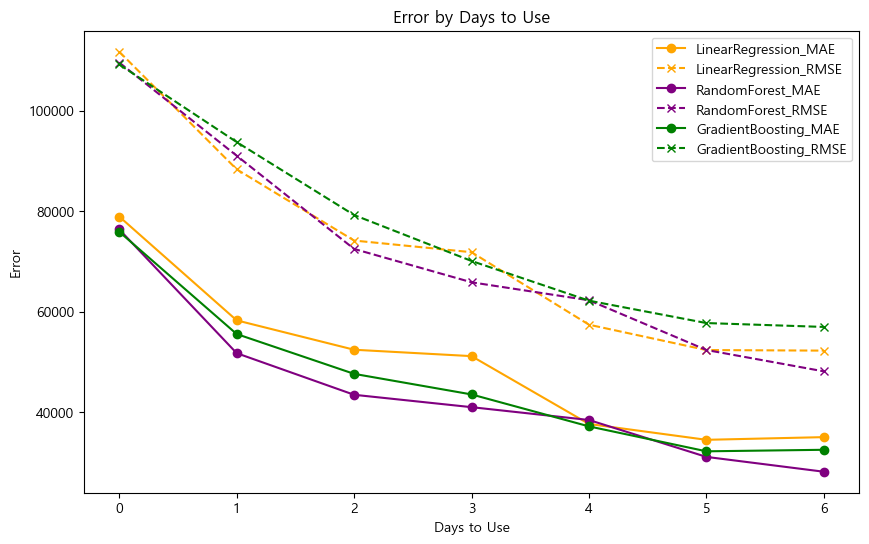

In [126]:
# 0~7일 데이터를 사용하여 11일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
colors = ['orange', 'purple', 'green']

plt.figure(figsize=(10, 6))
for model_name, color in zip(base_model_week2['Model'].unique(), colors):
    model_results = base_model_week2[(base_model_week2['Model'] == model_name) & (base_model_week2['Predict Day'] == 11)]
    plt.plot(model_results['Days to Use'], model_results['MAE'], label=model_name+'_MAE', color=color, marker='o')
    plt.plot(model_results['Days to Use'], model_results['RMSE'], label=model_name+'_RMSE', color=color, linestyle='--', marker='x')

plt.xlabel('Days to Use')
plt.ylabel('Error')
plt.title('Error by Days to Use')
plt.legend()
plt.show()

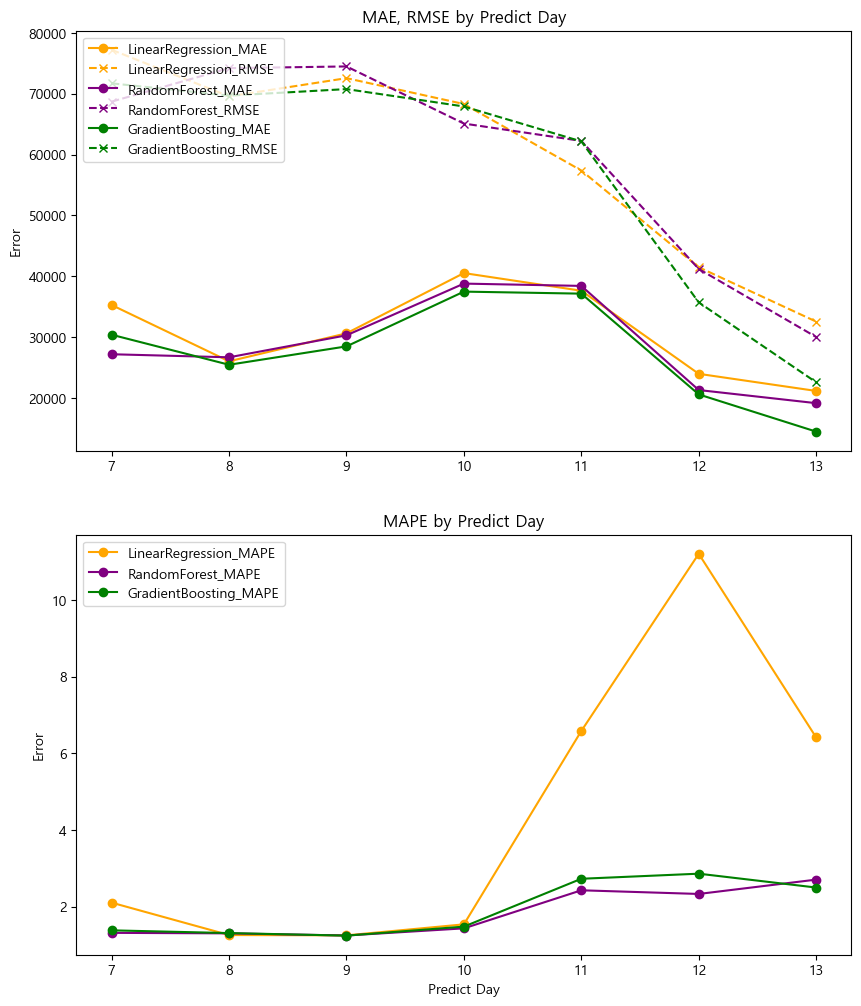

In [ ]:
# 4일 데이터를 사용하여 8~14일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
plot_prediction_error(base_model_week2, days_to_use=4)

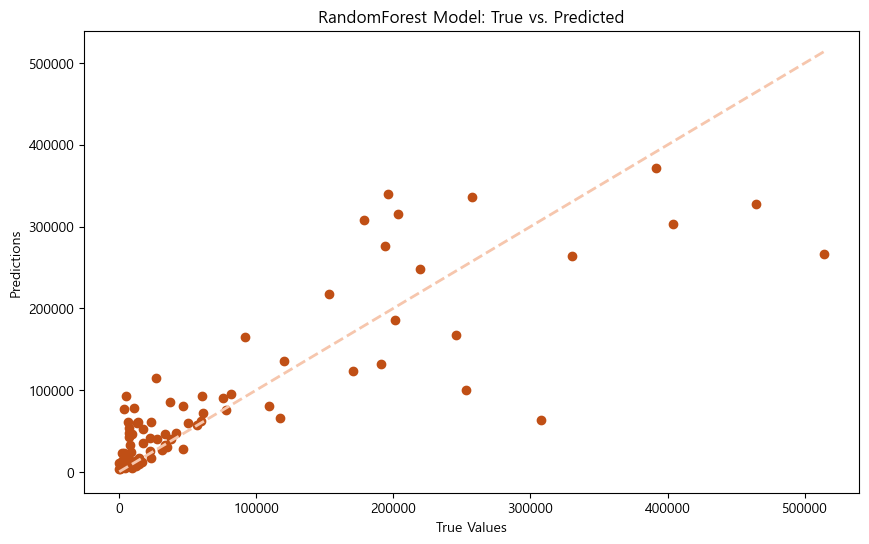

평가 지표:
MAE: 38414.027926829265
RMSE: 62244.70824840692
MAPE: 2.4301711013703473


In [216]:
X, y, model = plot_test_predict_scatter(pivoted_data_d, data_D, ts_data, base_create_X_y, 'RandomForest', 4, 11, model_type='base')

### b) Developed 모델

In [142]:
days_to_use = 4
pivoted_data_d[[f'score_total_{days_to_use}', f'hit_movie_power_{days_to_use}', f'review_participation_mean_{days_to_use}']]

,,score_total_4,hit_movie_power_4,review_participation_mean_4
kobis_movie_code,movie_title,,,
20068576,그날의 분위기,14.35,0.0,0.002501
20140704,비밀은 없다,13.60,0.0,0.006911
20142406,탐정 홍길동: 사라진 마을,15.98,0.0,0.003946
20142621,시간이탈자,14.98,0.0,0.005057
20142641,나를 잊지 말아요,13.43,0.0,0.006099
...,...,...,...,...
20198453,롱 리브 더 킹: 목포 영웅,16.19,0.0,0.006008
20198598,명탐정 피카츄,16.61,0.0,0.004991
20198982,크게 될 놈,17.93,0.0,0.019702


In [205]:
# developed 모델에서 사용할 독립변수와 종속변수를 분리
def developed_create_X_y(pivoted_data_d, data_D, ts_data, days_to_use, predict_day):
    # data_d에서 '관객수', '영화명 검색량', 'review_participation'을 포함한 컬럼을 가져옴
    pre_X = pivoted_data_d[[col for col in pivoted_data_d.columns if '관객수' in col or '영화명_검색량' in col]].copy()

    # 사용 날짜 기준을 정의
    pre_X = pre_X[[col for col in pre_X.columns if int(col.split('_')[-1]) < days_to_use]]

    # 평점 및 댓글 참여도 정보를 가져옴 (days_to_use 당일 정보)
    temp = pivoted_data_d[[f'score_total_{days_to_use}', f'hit_movie_power_{days_to_use}', f'review_participation_mean_{days_to_use}']]

    # X와 temp를 합침
    pre_X = pre_X.join(temp, on=['kobis_movie_code', 'movie_title'])

    # 예측날짜의 영화수요 예측 정보를 가져옴
    temp2 = pivoted_data_d[['release_date']].copy()
    temp2['forecast_' + str(predict_day)] = temp2['release_date'].map(lambda x: ts_data.loc[x + pd.Timedelta(days=predict_day), 'actual'])

    # X와 temp2를 합침
    pre_X = pre_X.join(temp2, on=['kobis_movie_code', 'movie_title'])

    # 개봉일 컬럼 드랍
    pre_X.drop(columns=['release_date'], inplace=True)

    # 종속변수 y
    pre_y = data_D[data_D['D_D'] == predict_day][['y_audiCnt']]

    # 인덱스 순서를 위해서 병합 해줌
    df = pre_X.merge(pre_y, left_index=True, right_index=True)
    X = df.drop(columns=['y_audiCnt'])
    y = df['y_audiCnt']

    return X, y

---

In [206]:
dev_model_week_2 = run_model(pivoted_data_d, data_D, ts_data, developed_create_X_y, models=models, week=2)

#### 모델 성능 비교

In [208]:
# 모델별 평균 결과
dev_model_week_2.groupby('Model')[['train_R^2', 'test_R^2', 'MAE', 'RMSE', 'MAPE']].mean()

,train_R^2,test_R^2,MAE,RMSE,MAPE
Model,,,,,
GradientBoosting,0.958776,0.459194,33320.229626,69553.091655,3.229072
LinearRegression,0.549789,0.483442,38206.018602,69763.947527,5.048835
RandomForest,0.926452,0.548295,32141.747546,65618.937724,2.764283


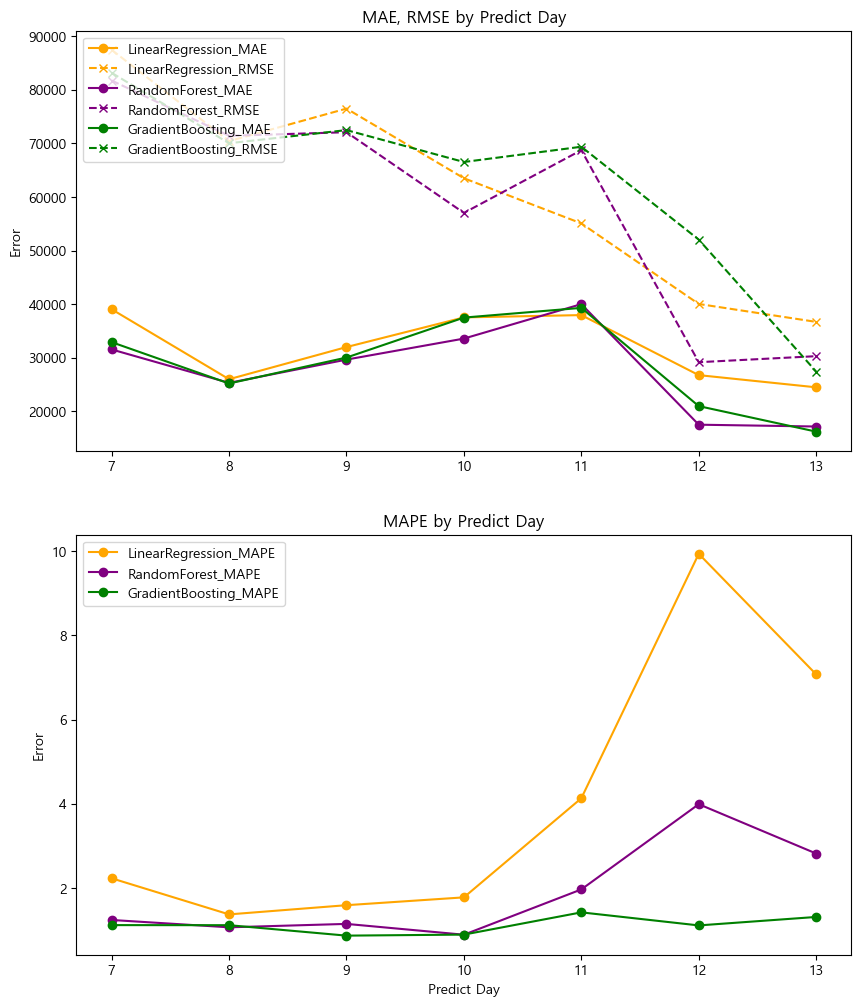

In [209]:
# 4일 데이터를 사용하여 8~14일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
plot_prediction_error(dev_model_week_2, 4)

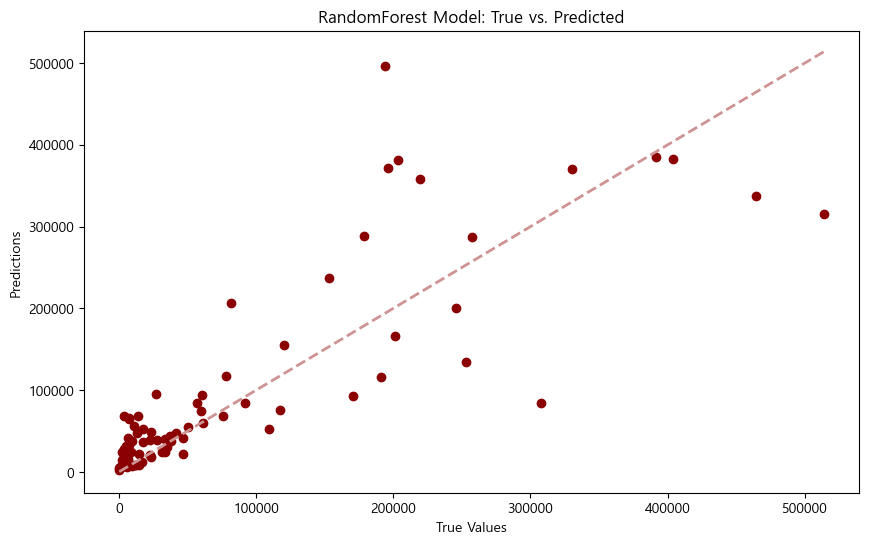

평가 지표:
MAE: 39986.13207317073
RMSE: 68731.18135635268
MAPE: 1.9673555202659327


In [215]:
# Developed 모델을 사용한 2주차 예측 결과 시각화
X, y, model = plot_test_predict_scatter(pivoted_data_d, data_D, ts_data, developed_create_X_y, 'RandomForest', 4, 11, model_type='developed')

## 3주차 관객수 예측

### 독립/종속변수 정의

In [217]:
dev_model_week_3 = run_model(pivoted_data_d, data_D, ts_data, developed_create_X_y, models=models, week=3)

### 모델 성능 비교

In [218]:
dev_model_week_3.groupby('Model')[['train_R^2', 'test_R^2', 'MAE', 'RMSE', 'MAPE']].mean()

,train_R^2,test_R^2,MAE,RMSE,MAPE
Model,,,,,
GradientBoosting,0.994008,0.504298,15222.134149,41565.061364,0.946278
LinearRegression,0.712302,0.433845,20891.785265,44248.315639,2.079245
RandomForest,0.944645,0.506236,15408.098201,41592.889958,0.916957


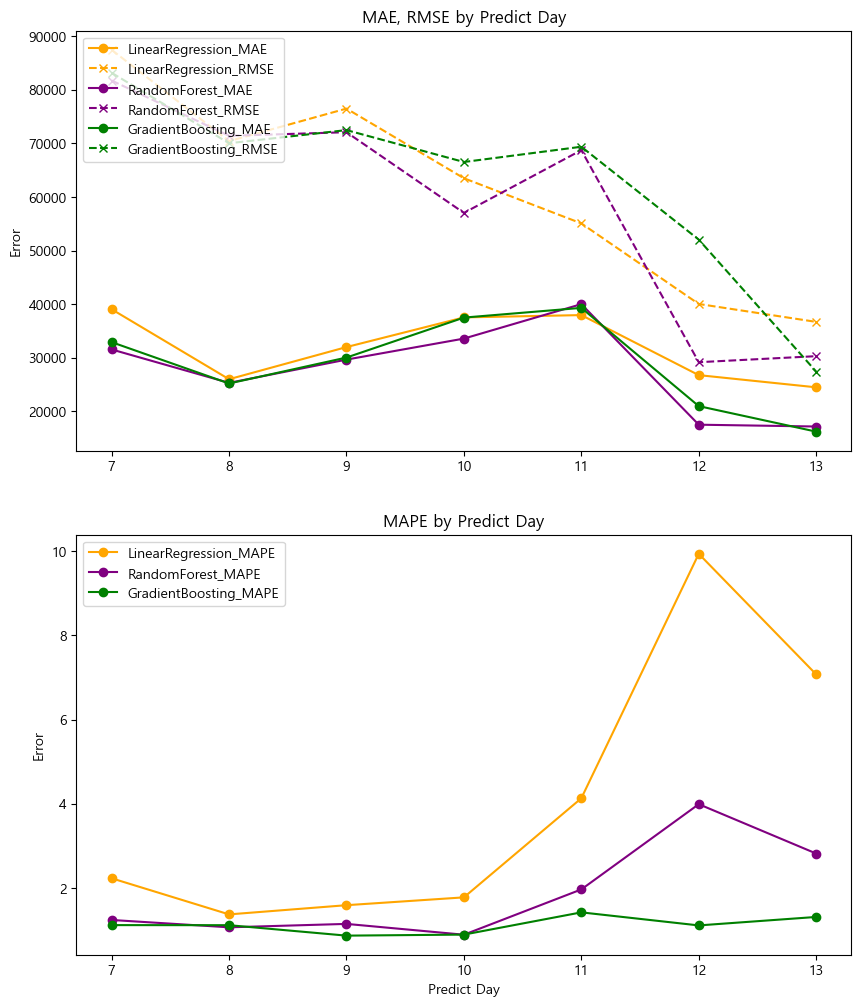

In [219]:
# 11일 데이터를 사용하여 14~20일 예측 평균 에러 시각화 (모델별 다른 선으로 표시)
plot_prediction_error(dev_model_week_2, 4)

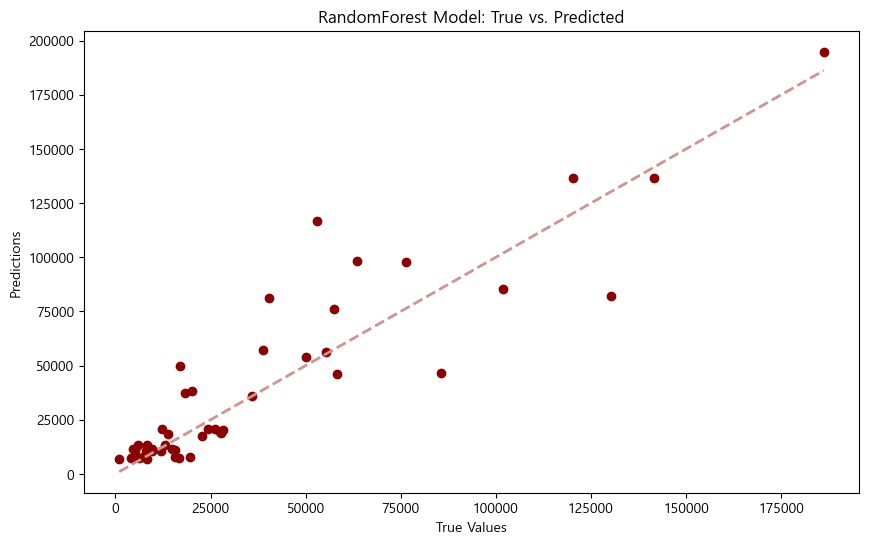

평가 지표:
MAE: 11636.185208333334
RMSE: 17954.64197861824
MAPE: 0.5679966113813748


In [222]:
# Developed 모델을 사용한 3주차 예측 결과 시각화
X, y, model = plot_test_predict_scatter(pivoted_data_d, data_D, ts_data, developed_create_X_y, 'RandomForest', 11, 17, model_type='developed')